In [2]:
import pickle
from typing import DefaultDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# results_file = open('/Users/duncan/Downloads/meta_perf_vs_num_train.pkl', 'rb')
results_file = open('/Users/duncan/Downloads/meta_perf_vs_num_train_fixed_200trials.pkl', 'rb')  # new file
all_results = pickle.load(results_file)
results_file.close()


Bad key savefig.frameon in file /Users/duncan/miniconda3/envs/recsys/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /Users/duncan/miniconda3/envs/recsys/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /Users/duncan/miniconda3/envs/recsys/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or

In [3]:
### Helper

from matplotlib import transforms


def draw_dodge(*args, **kwargs):
    func = args[0]
    dodge = kwargs.pop("dodge", 0)
    ax = kwargs.pop("ax", plt.gca())
    trans = ax.transData  + transforms.ScaledTranslation(dodge/72., 0,
                                   ax.figure.dpi_scale_trans)
    artist = func(*args[1:], **kwargs)
    def iterate(artist):
        if hasattr(artist, '__iter__'):
            for obj in artist:
                iterate(obj)
        else:
            artist.set_transform(trans)
    iterate(artist)
    return artist


In [4]:
# (num_trials is just used to verify all evaluations succeeded)
num_trials = 200
metric = "perc_diff_from_best_global"
#metric = 'mae'

models = ['xgboost', 'random', 'knn', 'linear']

In [5]:


results_per_model = {model: DefaultDict(list) for model in models}
for dataset in all_results:
    for trial in all_results[dataset]:
        num_train = all_results[dataset][trial]['num_train']
        for model in all_results[dataset][trial]:
            # note: it's not so safe to do this, where we throw away the the num_* and hard-code it later.
            if model in ['num_train', 'num_algs', 'num_feats']: continue
            for n_train, perf in zip(num_train, all_results[dataset][trial][model]):
                results_per_model[model][n_train].append(perf[metric])



In [6]:
medians = {}
means = {}
p1s = {}
p3s = {}
for model in models:
    means[model] = []
    medians[model] = []
    p1s[model] = []
    p3s[model] = []
    # needs to match the range in the python file
    for n_train in range(2, 20, 2):
        assert len(results_per_model[model][n_train]) == 19 * num_trials
        means[model].append(np.mean(results_per_model[model][n_train]))
        medians[model].append(np.median(results_per_model[model][n_train]))
        p1s[model].append(np.percentile(results_per_model[model][n_train], 40))
        p3s[model].append(np.percentile(results_per_model[model][n_train], 60))

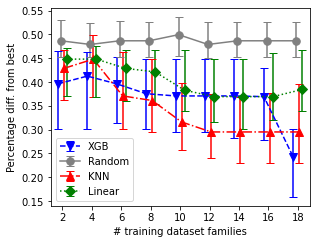

In [34]:
method_dict = {
    "xgboost": {
        "name": "XGB",
        "kwargs": {
            "marker": "v",
            "color": "blue",
            "linestyle": "--",
        }
    },
    "linear": {
        "name": "Linear",
        "kwargs": {
            "marker": "D",
            "color": "green",
            "linestyle": ":",
        }
    },    
    "knn": {
        "name": "KNN",
        "kwargs": {
            "marker": "^",
            "color": "red",
            "linestyle": "-.",
        }
    },
    "random": {
        "name": "Random",
        "kwargs": {
            "marker": "o",
            "color": "gray",
            "linestyle": "-",
        }
    }
}


dodge = np.arange(4,dtype=float)*3
dodge -= dodge.mean()


# plot with fill between 40-60% of trials

# note: when plotting mae, random and linear are very bad

x = [i for i in range(2, 20, 2)]

fig, ax = plt.subplots(figsize=(4.5, 3.5))

for i,model in enumerate(models):
    # plt.plot(x, medians[model], label=method_dict[model]["name"], **method_dict[model]["kwargs"])
    # plt.fill_between(x, p1s[model], p3s[model], alpha=0.1, color=method_dict[model]["kwargs"]["color"])
    yerr = np.array([(x - small, large - x) for x, small, large in zip(medians[model], p1s[model], p3s[model])]).T
    # err_minus = [x - small for m, small in zip(medians[model], p1s[model])]
    # plt.errorbar(x, medians[model], yerr=yerr, capsize=4, **method_dict[model]["kwargs"])
    draw_dodge(ax.errorbar, x, medians[model], yerr=yerr, ax=ax, dodge=dodge[i], capsize=4, markersize=7.5, label=method_dict[model]["name"], **method_dict[model]["kwargs"])

ax.set_xticks(np.arange(2, 19, 2))
plt.legend()
plt.xlabel('# training dataset families')
plt.ylabel('Percentage diff. from best')
plt.tight_layout()
plt.savefig('./plot_files/perf_vs_datasets_plot.pdf')
plt.show()

